In [39]:
from ipywidgets import interact_manual, interact, fixed
import ipywidgets as widgets
from sage.all import *
from sage.databases.findstat import FindStatMaps, FindStatStatistics
import requests
import json
findstat()._allow_execution = True
from sage.rings.rational_field import QQ
from dataclasses import dataclass
from sage.dynamics.finite_dynamical_system import FiniteDynamicalSystem
from sage.structure.parent import Parent
import matplotlib.pyplot as plt
import numpy as np
from itertools import product






In [2]:
findstat_collection = (
    (Permutations, "Permutations", Permutation),
    (ParkingFunctions, "Parking functions", ParkingFunction),
    # (Partitions, "Integer partitions", Partition),
    # (PlanePartitions, "Plane partitions", PlanePartition),
    # (DyckWords, "Dyck paths", DyckWord),
)


@dataclass
class CollectionWithMapsAndStats:
    collection: object
    name: str
    stats: list
    maps: list
    element_constructor: callable


all_collections: dict[str, CollectionWithMapsAndStats] = {}

for c, n, e in findstat_collection:
    print(f"Downloading data for {n}")
    maps = FindStatMaps(domain=n, codomain=n)
    maps = list(filter(lambda x: x.properties_raw().find("bijective") >= 0, maps))
    collection = CollectionWithMapsAndStats(c, n, list(FindStatStatistics(n)), maps, e)
    all_collections[n] = collection
print("done downloading data")
print("printing stats...")
all_collections

done downloading data
printing stats...


{'Permutations': CollectionWithMapsAndStats(collection=<class 'sage.combinat.permutation.Permutations'>, name='Permutations', stats=[St000001: The number of reduced words for a permutation., St000002: The number of occurrences of the pattern 123 in a permutation., St000004: The major index of a permutation., St000007: The number of saliances of the permutation., St000018: The number of inversions of a permutation., St000019: The cardinality of the support of a permutation., St000020: The rank of the permutation., St000021: The number of descents of a permutation., St000022: The number of fixed points of a permutation., St000023: The number of inner peaks of a permutation., St000028: The number of stack-sorts needed to sort a permutation., St000029: The depth of a permutation., St000030: The sum of the descent differences of a permutations., St000031: The number of cycles in the cycle decomposition of a permutation., St000033: The number of permutations greater than or equal to the give

In [3]:
class FunctionWithName:
    def __init__(self, f, name):
        self.f = f
        self.name = name

    def __call__(self, *args, **kwargs):
        return self.f(*args, **kwargs)

    def __str__(self):
        return self.name

    def __repr__(self):
        return self.name


class ListWrapper:
    def __init__(self, lst):
        if isinstance(lst, self.__class__):
            self.lst = list(lst.lst)
            self.n = lst.n
        else:
            self.lst = list(lst)
            self.n = len(lst)

    def __iter__(self):
        return iter(self.lst)

    def __getitem__(self, i):
        return self.lst[i]

    def __len__(self):
        return len(self.lst)

    def __str__(self):
        return str(self.lst)

    def __repr__(self):
        return str(self.lst)
    
    def __eq__(self, value):
        try:
            return self.lst == list(value)
        except:
            return False
        
    def __hash__(self):
        return hash(tuple(self.lst))
    
class IntegerListWrapper(ListWrapper):
    def number_of_fixed_points(self):
        return sum([1 for i in range(len(self)) if i + 1 == self[i]])
    

In [4]:
def is_fubini_ranking(lst: list):
    n = len(lst)
    for i in range(1, n + 1):
        count = lst.count(i)
        for j in range(1, count):
            if i + j in lst:
                return False
    return True


def generate_fubini_rankings(n: int):
    p = ParkingFunctions(n)
    for pf in p:
        if is_fubini_ranking(pf):
            yield pf

    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False
        return self.n == other.n and self.lst == other.lst

    def __hash__(self):
        return hash(tuple(self.lst))


class FubiniRanking(IntegerListWrapper):
    def reverse(self):
        return FubiniRanking(list(reversed(self.lst)))


class FubiniRankings(Parent, ListWrapper):
    def __init__(self, n):
        if isinstance(n, list):
            ListWrapper.__init__(self, list([FubiniRanking(x) for x in n]))
        elif isinstance(n, int):
            ListWrapper.__init__(
                self, list([FubiniRanking(x) for x in generate_fubini_rankings(n)])
            )
        else:
            raise ValueError("n must be either a list or an integer")

    def __str__(self):
        return f"Fubini ranking of size {self.n}"

    def __repr__(self):
        return f"Fubini ranking of size {self.n}"


all_collections["Fubini rankings"] = CollectionWithMapsAndStats(
    FubiniRankings, "Fubini rankings", [], [], FubiniRanking
)
list(FubiniRankings(3))

[[1, 1, 1],
 [1, 1, 3],
 [1, 3, 1],
 [3, 1, 1],
 [1, 2, 2],
 [2, 1, 2],
 [2, 2, 1],
 [1, 2, 3],
 [1, 3, 2],
 [2, 1, 3],
 [2, 3, 1],
 [3, 1, 2],
 [3, 2, 1]]

In [5]:
# yoinked from https://11011110.github.io/blog/2013/03/13/cayley-permutations.html
def generate_cayley_permutations(n):
    """Generate sequence of Cayley permutations of length n"""
    if n < 2:
        yield [1] * n
        return
    for P in generate_cayley_permutations(n - 1):
        m = max(P)
        i = n - 1
        P = P + [m + 1]
        pastMax = False
        yield P
        while i > 0:
            if not pastMax:
                P[i] = m
                yield P
                if P[i - 1] == m:
                    pastMax = True
            P[i] = P[i - 1]
            P[i - 1] = m + 1
            i -= 1
            yield P


class CayleyPermutation(IntegerListWrapper):
    pass


class CayleyPermutations(Parent, ListWrapper):
    def __init__(self, n):
        if isinstance(n, list):
            ListWrapper.__init__(self, list([CayleyPermutation(x) for x in n]))
        elif isinstance(n, int):
            ListWrapper.__init__(
                self,
                list([CayleyPermutation(x) for x in generate_cayley_permutations(n)]),
            )
        else:
            raise ValueError("n must be either a list or an integer")

    def __str__(self):
        return f"Cayley permutation of size {self.n}"

    def __repr__(self):
        return f"Cayley permutation of size {self.n}"


all_collections["Cayley permutations"] = CollectionWithMapsAndStats(
    CayleyPermutations, "Cayley permutations", [], [], CayleyPermutation
)
list(CayleyPermutations(3))

[[1, 2, 3],
 [1, 2, 2],
 [1, 3, 2],
 [3, 1, 2],
 [1, 1, 2],
 [1, 1, 1],
 [1, 2, 1],
 [2, 1, 1],
 [2, 1, 3],
 [2, 1, 2],
 [2, 3, 1],
 [2, 2, 1],
 [3, 2, 1]]

In [6]:
def generate_tuples(n, iter_to=None):
    if iter_to is None:
        iter_to = n
    if n == 0:
        yield []
        return
    for p in generate_tuples(n - 1, iter_to):
        for i in range(1, iter_to + 1):
            yield [i] + p


class NTuple(IntegerListWrapper):
    pass


class NTuples(Parent, ListWrapper):
    def __init__(self, n):
        if isinstance(n, list):
            ListWrapper.__init__(self, list([NTuple(x) for x in n]))
        elif isinstance(n, int):
            ListWrapper.__init__(self, list([NTuple(x) for x in generate_tuples(n)]))
        else:
            raise ValueError("n must be either a list or an integer")

    def __str__(self):
        return f"All tuples of size {self.n}"

    def __repr__(self):
        return f"All tuples of size {self.n}"


def get_add_n_map(n):
    def add_n(p):
        return NTuple([(x + n - 1) % len(p) + 1 for x in p])

    return FunctionWithName(add_n, f"Add {n} to each element")


def get_subtract_n_map(n):
    def subtract_n(p):
        return NTuple([(x - n - 1) % len(p) + 1 for x in p])

    return FunctionWithName(subtract_n, f"Subtract {n} from each element")


def get_mult_n_map(n):
    def mult_n(p):
        return NTuple([(x * n - 1) % len(p) + 1 for x in p])

    return FunctionWithName(mult_n, f"Multiply each element by {n}")


fixed_point_statistic = FunctionWithName(IntegerListWrapper.number_of_fixed_points, "Number of fixed points")
cosine = FunctionWithName(lambda x: sum(x[i]*(i+1) for i in range(len(x))), "Cosine")

id = FunctionWithName(lambda x: x, "Identity")
reverse = FunctionWithName(lambda x: NTuple(list(reversed(list(x)))), "Reverse")
complement = FunctionWithName(lambda x: NTuple(list(len(x) - e + 1 for e in x)), "Complement")


all_collections["n-tuples"] = CollectionWithMapsAndStats(
    NTuples,
    "n-tuples",
    [cosine, fixed_point_statistic],
    [get_add_n_map(n) for n in range(1, 6)]
    #+ [get_subtract_n_map(n) for n in range(1, 6)]
    + [get_mult_n_map(n) for n in range(1, 6)]
    + [id, reverse, complement],
    NTuple,
)

list(NTuples(3))

[[1, 1, 1],
 [2, 1, 1],
 [3, 1, 1],
 [1, 2, 1],
 [2, 2, 1],
 [3, 2, 1],
 [1, 3, 1],
 [2, 3, 1],
 [3, 3, 1],
 [1, 1, 2],
 [2, 1, 2],
 [3, 1, 2],
 [1, 2, 2],
 [2, 2, 2],
 [3, 2, 2],
 [1, 3, 2],
 [2, 3, 2],
 [3, 3, 2],
 [1, 1, 3],
 [2, 1, 3],
 [3, 1, 3],
 [1, 2, 3],
 [2, 2, 3],
 [3, 2, 3],
 [1, 3, 3],
 [2, 3, 3],
 [3, 3, 3]]

In [7]:
def generate_inversion_sequences(n):
    for p in Permutations(n):
        yield [sum([1 for j in range(i) if p[j] > p[i]]) for i in range(n)]


class InversionSequence(IntegerListWrapper):
    pass


class InversionSequences(Parent, ListWrapper):
    def __init__(self, n):
        if isinstance(n, list):
            ListWrapper.__init__(self, list([InversionSequence(x) for x in n]))
        elif isinstance(n, int):
            ListWrapper.__init__(
                self,
                list([InversionSequence(x) for x in generate_inversion_sequences(n)]),
            )
        else:
            raise ValueError("n must be either a list or an integer")

    def __str__(self):
        return f"Inversion sequences of size {self.n}"

    def __repr__(self):
        return f"Inversion sequences of size {self.n}"


def get_add_k_map_zero_based(k):
    def add_k(p):
        return InversionSequence([(x + k) % len(p) for x in p])

    return FunctionWithName(add_k, f"Add {k} to each element zero-based")


def get_subtract_k_map_zero_based(k):
    def subtract_k(p):
        return InversionSequence([(x - k) % len(p) for x in p])
    
    return FunctionWithName(subtract_k, f"Subtract {k} from each element zero-based")


def get_mult_k_map_zero_based(k):
    def mult_k(p):
        return InversionSequence([(x * k) % len(p) for x in p])

    return FunctionWithName(mult_k, f"Multiply each element by {k} zero-based")


all_collections["Inversion sequences"] = CollectionWithMapsAndStats(
    InversionSequences,
    "Inversion sequences",
    [
        FunctionWithName(
            lambda l: len([1 for i in range(len(l)) if l[i] == i]),
            "Number of fixed points zero-based",
        ),
    ],
    [get_add_k_map_zero_based(k) for k in range(1, 6)]
    #+ [get_subtract_k_map_zero_based(k) for k in range(1, 6)]
    + [get_mult_k_map_zero_based(k) for k in range(1, 6)],
    InversionSequence,
)

In [8]:

def ana(name, **kwargs):
    def wrapper(f):
        f.__ana_name__ = name
        f.__ana_kwargs__ = kwargs
        return f

    return wrapper


class ListAnalysis(IntegerListWrapper):
    @ana("Number of each number")
    def number_counts(self):
        return ListAnalysis([sum([1 for x in self if x == i]) for i in range(1, len(self) + 1)])

    @ana("Number of unique elements")
    def unique_elements(self):
        return len(set(self))

    @ana(
        "Number of sequences of length {seq_len} that are increasing by {increase_by}",
        seq_len=(2, "n+1"),
        increase_by=(-1, 2),
    )
    def equally_increasing_sequences(self, seq_len, increase_by=0):
        r = [0] * (len(self))
        for i in range(len(self) - seq_len + 1):
            if all([self[i + j] == self[i] + j * increase_by and self[i] > 0 for j in range(seq_len)]):
                r[self[i] - 1] += 1
        return ListAnalysis(r)

    @ana(
        "Number of sequences of length {seq_len} that are increasing by {increase_by} with a loop",
        seq_len=(2, "n+1"),
        increase_by=(-1, 2),
    )
    def equally_increasing_sequences_with_loop(self, seq_len, increase_by=0):
        r = [0] * (len(self))
        for i in range(len(self)):
            if all(
                [
                    self[(i + j) % len(self)] == self[i] + j * increase_by and self[i] > 0
                    for j in range(seq_len)
                ]
            ):
                r[self[i] - 1] += 1
        return ListAnalysis(r)

    @ana("Exists number")
    def exists_number(self):
        return list([True if self[i] > 0 else False for i in range(len(self))])
    
    @ana("Element greater then zero")
    def element_greater_than_zero(self):
        return list([True if x > 0 else False for x in self])
    

    @ana("Number of elements less than each number")
    def elements_less_than(self):
        return ListAnalysis(
            [sum([1 for j in self if j < i]) for i in range(1, len(self) + 1)]
        )

    @ana("Number of elements greater than each number")
    def elements_greater_than(self):
        return ListAnalysis(
            [sum([1 for j in self if j > i]) for i in range(1, len(self) + 1)]
        )

    @ana("Number of elements less than each element to the left")
    def elements_to_the_left_smaller(self):
        return ListAnalysis(
            [sum([1 for j in self[:i - 1] if j < self[i - 1]]) for i in range(1, len(self) + 1)]
        )

    @ana("Number of elements less than each element to the right")
    def elements_to_the_right_smaller(self):
        return ListAnalysis(
            [sum([1 for j in self[i:] if j < self[i - 1]]) for i in range(1, len(self) + 1)]
        )

    @ana("Number of elements greater than each element to the left")
    def elements_to_the_left_larger(self):
        return ListAnalysis(
            [sum([1 for j in self[:i - 1] if j > self[i - 1]]) for i in range(1, len(self) + 1)]
        )

    @ana("Number of elements greater than each element to the right")
    def elements_to_the_right_larger(self):
        return ListAnalysis(
            [sum([1 for j in self[i:] if j > self[i - 1]]) for i in range(1, len(self) + 1)]
        )

    def get_all_analyser(self):
        return [
            getattr(self, x)
            for x in dir(self)
            if hasattr(getattr(self, x), "__ana_name__")
        ]

    def create_analysis(self, depth=2, prefix=tuple(), results=None, filter_zero_sequences=True):
        if results is None:
            results = {}
        if depth <= 0:
            return
        for a in self.get_all_analyser():
            if a.__ana_kwargs__:
                keys = list(a.__ana_kwargs__.keys())
                values = list(a.__ana_kwargs__.values())
                mapped_values = []
                for i in range(len(values)):
                    mapped_values.append([0,0]) 
                    for j in range(2):
                        if isinstance(values[i][j], str):
                            mapped_values[i][j] = values[i][j].replace("n", str(len(self)))
                            mapped_values[i][j] = int(eval(mapped_values[i][j]))
                        else:
                            mapped_values[i][j] = values[i][j]
                    mapped_values[i] = range(*mapped_values[i])
                for p in product(*mapped_values):
                    r = a(*p)
                    new_prefix = prefix + tuple([a.__ana_name__.format(**dict(zip(keys, p)))])
                    results[new_prefix] = r
                    if isinstance(r, ListAnalysis) and any(x > 0 for x in r):
                        r.create_analysis(depth=depth - 1, prefix=new_prefix, results=results)
            else:
                r = a()
                new_prefix = prefix + tuple([a.__ana_name__])
                results[new_prefix] = r
                if isinstance(r, ListAnalysis) and any(x > 0 for x in r):
                    r.create_analysis(depth=depth - 1, prefix=new_prefix, results=results)
        
        if len(prefix) == 0 and filter_zero_sequences:
            return dict(filter(lambda x: not isinstance(x[1], ListAnalysis) or not all([y == 0 for y in x[1]]), results.items()))
        return results


def find_patterns(elements, depth=2, filter_zero_sequences=False):
    elements = list([ListAnalysis(x) for x in elements])
    ana_results = list([x.create_analysis(depth=depth, filter_zero_sequences=filter_zero_sequences) for x in elements])
    keys = set(ana_results[0].keys())
    for r in ana_results:
        keys.intersection_update(r.keys())
    
    results = {}
    
    for key in keys:
        if all([r[key] == ana_results[0][key] for r in ana_results]):
            results[key] = ana_results[0][key]
            
    return results, ana_results

In [9]:
def format_row(x, y, ins):
    if ins:
        return f"{x}: {y}"
    else:
        return f"({x}: {y})"


def print_row(avg, cycle, stats, in_set):
    t = [format_row(x, y, inss) for x, y, inss in zip(cycle, stats, in_set)]
    if all(in_set):
        print(f"{avg}:\t {' -> '.join(t)}")
    else:
        print(f"*{avg}:\t {' -> '.join(t)}")


@dataclass
class HomomesyResult:
    all_avgs: list
    all_cycles: list
    all_stats: list
    all_in_sets: list

    def is_homomesic(self):
        return all([x == self.all_avgs[0] for x in self.all_avgs])

    def is_homomesic_in_set(self):
        return all(
            [
                x == self.all_avgs[0]
                for x, _ in filter(
                    lambda x: all(x[1]), zip(self.all_avgs, self.all_in_sets)
                )
            ]
        )

    def is_homometric(self):
        len_queue_queue = list(set([len(c) for c in self.all_cycles]))
        is_homometric = True
        for l in len_queue_queue:
            avgs = list(
                [a for a, x in zip(self.all_avgs, self.all_cycles) if len(x) == l]
            )
            if not all([x == avgs[0] for x in avgs]):
                is_homometric = False
                break
        return is_homometric

    def is_homometric_in_set(self):
        len_queue_queue = list(set([len(c) for c in self.all_cycles]))
        is_homometric = True
        for l in len_queue_queue:
            avgs = list(
                [a for a, x in zip(self.all_avgs, self.all_cycles) if len(x) == l]
            )
            in_sets = list(
                [x for x, y in zip(self.all_in_sets, self.all_cycles) if len(y) == l]
            )
            if not all([x == avgs[0] for x, y in zip(avgs, in_sets) if all(y)]):
                is_homometric = False
                break
        return is_homometric

    def get_grouped_orbits(self):
        avg_queue = list(set(self.all_avgs))
        grouped_orbits = {}
        while avg_queue:
            avg = avg_queue.pop()
            grouped_orbits[avg] = HomomesyResult([], [], [], [])
            for a, c, s, ins in zip(
                self.all_avgs, self.all_cycles, self.all_stats, self.all_in_sets
            ):
                if a == avg:
                    grouped_orbits[avg].all_avgs.append(a)
                    grouped_orbits[avg].all_cycles.append(c)
                    grouped_orbits[avg].all_stats.append(s)
                    grouped_orbits[avg].all_in_sets.append(ins)
        return grouped_orbits

    def get_all_elements(self):
        return sum(self.all_cycles, [])

    def find_patterns(self, depth=2, filter_zero_sequences=False):
        return find_patterns(
            self.get_all_elements(),
            depth=depth,
            filter_zero_sequences=filter_zero_sequences,
        )

    def print_all_cycles(self):
        for a, c, s, ins in zip(
            self.all_avgs, self.all_cycles, self.all_stats, self.all_in_sets
        ):
            print_row(a, c, s, ins)

    def print_result(self):
        print(f"Homomesic: {self.is_homomesic()}")
        print(f"Homomesic using only cycles in set: {self.is_homomesic_in_set()}")
        print(f"Homometric: {self.is_homometric()}")
        print(f"Homometric using only cycles in set: {self.is_homometric_in_set()}")

    def print_grouped_orbits(self):
        for avg, res in self.get_grouped_orbits().items():
            print(f"Orbit with average {avg}")
            print()
            res.print_all_cycles()
            print()

    def find_unique_patterns_per_group(self, depth=2, filter_zero_sequences=False):
        grouped_orbits = list(self.get_grouped_orbits().values())
        all_patterns_per_group, full_pattern_list = zip(
            *[
                x.find_patterns(
                    depth=depth, filter_zero_sequences=filter_zero_sequences
                )
                for x in grouped_orbits
            ]
        )

        unique_patterns = [{} for _ in range(len(all_patterns_per_group))]
        for i in range(len(all_patterns_per_group)):
            for pattern, val in all_patterns_per_group[i].items():
                unique = True
                for j in range(len(full_pattern_list)):
                    if i != j:
                        for other_pattern_dict in full_pattern_list[j]:
                            if other_pattern_dict.get(pattern, None) == val:
                                unique = False
                                break
                        if not unique:
                            break

                if unique:
                    unique_patterns[i][pattern] = val

        def filter_dict(d):
            return dict(filter(lambda x: not (x[0][:-1] in d), d.items()))

        return [filter_dict(x) for x in unique_patterns], grouped_orbits

    def print_grouped_orbits_with_unique_patterns(
        self, depth=2, filter_zero_sequences=False
    ):
        all_patterns, all_orbits = self.find_unique_patterns_per_group(
            depth=depth, filter_zero_sequences=filter_zero_sequences
        )

        for patterns, orbits in zip(all_patterns, all_orbits):
            print(f"Orbits with average {orbits.all_avgs[0]}\n")
            if len(orbits.get_all_elements()) > 1:
                for pattern, val in patterns.items():
                    print(f"Unique pattern found: {' -> '.join(pattern)}: {val}")
            print()
            orbits.print_all_cycles()
            print("---------\n")

    def print_latex_orbit_code(
        self,
        main_circle_radius=6,
        orbit_circle_radius_map={1: 0, 2: 1, 4: 2, 8: 3},
        print_function=lambda p: "$(" + ", ".join([str(e) for e in p]) + ")$",
        x_stretch=1.2,
        print_avg=True,
    ):
        main_step_size = 2 * np.pi / len(self.all_cycles)
        for i, O in enumerate(self.all_cycles):
            x_center = main_circle_radius * np.sin(i * main_step_size)
            x_center *= x_stretch
            y_center = main_circle_radius * np.cos(i * main_step_size)
            orbit_step_size = 2 * np.pi / len(O)
            for j, p in enumerate(O):
                x = x_center + orbit_circle_radius_map[len(O)] * np.sin(
                    j * orbit_step_size
                )
                x *= x_stretch
                y = y_center + orbit_circle_radius_map[len(O)] * np.cos(
                    j * orbit_step_size
                )
                print(
                    f"\\node ({chr(i+97)}{j}) at ({x:.3f}, {y:.3f}) {{{print_function(p)}}};"
                )
            print()

            def get_anchor_start(j):
                name = chr(i + 97) + str(j)
                if j == 0:
                    return name + ".east"
                elif j < len(O) / 2:
                    return name + ".south"
                elif j == len(O) / 2:
                    return name + ".west"
                else:
                    return name + ".north"

            def get_anchor_end(j):
                name = chr(i + 97) + str(j % len(O))
                if j % len(O) == 0:
                    return name + ".west"
                elif j < len(O) / 2:
                    return name + ".north"
                elif j == len(O) / 2:
                    return name + ".east"
                else:
                    return name + ".south"

            def get_start_angle(j):
                angle = int(j * orbit_step_size / np.pi * 180)
                return (-angle + 720) % 360

            def get_end_angle(j):
                angle = int(j * orbit_step_size / np.pi * 180)
                return (-angle + 180 + 720) % 360

            for j in range(len(O)):
                print(
                    f"\\draw[->] ({get_anchor_start(j)}) to[out={get_start_angle(j)}, in={get_end_angle(j + 1)}] ({get_anchor_end(j + 1)});"
                )
            if print_avg:
                print()
                print(f"\\node at ({x_center*x_stretch:.3f}, {y_center:.3f}) {{{self.all_avgs[i]}}};")
            print("\n")

In [37]:
def lazy_cycles(F):
    visited = set()
    for e in F:
        if e in visited:
            continue
        orb = [e]
        in_set = [True]
        visited.add(e)
        curr = F._phi(e)
        while curr != e:
            if curr in orb:
                raise ValueError("Function is not a bijection. Orbit: " + " -> ".join([str(x) for x in orb + [curr]]))
            in_set.append(curr in F)
            visited.add(curr)
            orb.append(curr)
            curr = F._phi(curr)
        yield orb, in_set

def is_homomesic_with_debug(F, stat, pre_stat_map=lambda x: x, ignore_errors=False):
    all_avgs = []
    all_cycles = []
    all_stats = []
    all_in_sets = []


    for cyc, in_set in lazy_cycles(F):
        try:
            l = len(cyc)
            cur_cycle = list(cyc)
            cur_stats = [stat(pre_stat_map(x)) for x in cur_cycle]
            cur_avg = ~(QQ(l)) * sum(cur_stats)
            all_avgs.append(cur_avg)
            all_cycles.append(cur_cycle)
            all_stats.append(cur_stats)
            all_in_sets.append(in_set)
        except Exception as e:
            if ignore_errors:
                continue
            else:
                raise e


    return HomomesyResult(all_avgs, all_cycles, all_stats, all_in_sets)

def is_homomesic_with_debug_and_set_cycles(cycles, stat, pre_stat_map=None, ignore_errors=False):
    all_avgs = []
    all_stats = []
    all_in_sets = []
    all_cycles = [cyc for cyc, _ in cycles]
    
    for cyc, in_set in cycles:
        try:
            l = len(cyc)
            cur_cycle = list(cyc)
            if pre_stat_map is None:
                cur_stats = [stat(x) for x in cur_cycle]
            else:
                cur_stats = [stat(pre_stat_map(x)) for x in cur_cycle]
            cur_avg = ~(QQ(l)) * sum(cur_stats)
            all_avgs.append(cur_avg)
            all_stats.append(cur_stats)
            all_in_sets.append(in_set)
        except Exception as e:
            if ignore_errors:
                continue
            else:
                raise e
            
    return HomomesyResult(all_avgs, all_cycles, all_stats, all_in_sets)

In [11]:
colls = widgets.Dropdown(
    options=[(c.name, c) for c in all_collections.values()], description="Collection"
)
use_maps_from = widgets.Dropdown(
    options=[(c.name, c) for c in all_collections.values() if c.maps],
    description="Use maps from",
)
maps = widgets.Dropdown(
    options=all_collections[colls.value.name].maps, description="Map"
)
use_stats_from = widgets.Dropdown(
    options=[(c.name, c) for c in all_collections.values() if c.stats],
    description="Use stats from",
)
stats = widgets.Dropdown(
    options=all_collections[colls.value.name].stats, description="Statistic"
)
size = widgets.IntSlider(value=3, min=1, max=10, step=1, description="n")
ignore_errors = widgets.Checkbox(value=False, description="Ignore errors")
look_for_patterns = widgets.Checkbox(value=False, description="Look for patterns")
pattern_search_depth = widgets.IntSlider(
    value=1, min=1, max=4, step=1, description="Pattern search depth"
)
print_latex_code = widgets.Checkbox(value=False, description="Print latex code")


def on_update_maps_from(*args):
    maps.options = all_collections[use_maps_from.value.name].maps


def on_update_stats_from(*args):
    stats.options = all_collections[use_stats_from.value.name].stats


use_maps_from.observe(on_update_maps_from, "value")
use_stats_from.observe(on_update_stats_from, "value")


def evaluate(
    coll,
    func,
    stat,
    n,
    use_stats_from,
    use_maps_from,
    ignore_errors,
    look_for_patterns,
    pattern_search_depth,
    print_latex_code,
):
    if coll.name == use_maps_from.name:
        F = FiniteDynamicalSystem(coll.collection(n), func)
    elif ignore_errors:

        def mapper(x):
            try:
                return use_maps_from.element_constructor(x)
            except:
                return None

        mapped = [mapper(x) for x in coll.collection(n)]
        mapped = list(filter(lambda x: x is not None, mapped))
        F = FiniteDynamicalSystem(mapped, func)
    else:
        F = FiniteDynamicalSystem(
            list([use_maps_from.element_constructor(x) for x in coll.collection(n)]),
            func,
        )

    if use_stats_from.name == use_maps_from.name:
        r = is_homomesic_with_debug(F, stat, ignore_errors=ignore_errors)
    else:
        r = is_homomesic_with_debug(
            F, stat, use_stats_from.element_constructor, ignore_errors=ignore_errors
        )
    r.print_result()
    print()
    r.print_all_cycles()
    print("\n\n")
    if look_for_patterns:
        r.print_grouped_orbits_with_unique_patterns(
            depth=pattern_search_depth, filter_zero_sequences=True
        )
    else:
        r.print_grouped_orbits()

    if print_latex_code:
        r.print_latex_orbit_code()


interact_manual(
    evaluate,
    coll=colls,
    use_maps_from=use_maps_from,
    func=maps,
    use_stats_from=use_stats_from,
    stat=stats,
    n=size,
    ignore_errors=ignore_errors,
    look_for_patterns=look_for_patterns,
    pattern_search_depth=pattern_search_depth,
    print_latex_code=print_latex_code,
)

interactive(children=(Dropdown(description='Collection', options=(('Permutations', CollectionWithMapsAndStats(…

<function __main__.evaluate(coll, func, stat, n, use_stats_from, use_maps_from, ignore_errors, look_for_patterns, pattern_search_depth, print_latex_code)>

In [ ]:
colls = widgets.Dropdown(
    options=[(c.name, c) for c in all_collections.values()], description="Collection"
)
permutation_field = widgets.Text(placeholder="1234", description="Permutation:")
use_stats_from = widgets.Dropdown(
    options=[(c.name, c) for c in all_collections.values() if c.stats],
    description="Use stats from",
)
stats = widgets.Dropdown(
    options=all_collections[colls.value.name].stats, description="Statistic"
)
size = widgets.IntSlider(value=3, min=1, max=10, step=1, description="n")
ignore_errors = widgets.Checkbox(value=False, description="Ignore errors")
look_for_patterns = widgets.Checkbox(value=False, description="Look for patterns")
pattern_search_depth = widgets.IntSlider(
    value=1, min=1, max=4, step=1, description="Pattern search depth"
)
print_latex_code = widgets.Checkbox(value=False, description="Print latex code")


def on_update_stats_from(*args):
    stats.options = all_collections[use_stats_from.value.name].stats


use_stats_from.observe(on_update_stats_from, "value")


def evaluate(
    coll,
    perm_text,
    stat,
    n,
    use_stats_from,
    ignore_errors,
    look_for_patterns,
    pattern_search_depth,
    print_latex_code,
):
    perm_text = perm_text.replace(" ", "")
    perm = Permutation(list(map(int, perm_text)))
    print(
        f"Permutation: {perm} with order {perm.order()} and cyclic decomposition {perm.cycle_string()}\n"
    )

    F = FiniteDynamicalSystem(
        list(coll.collection(n)),
        lambda x: IntegerListWrapper(perm.action(x)),
    )

    r = is_homomesic_with_debug(
        F, stat, use_stats_from.element_constructor, ignore_errors=ignore_errors
    )
    r.print_result()
    print()
    r.print_all_cycles()
    print("\n\n")
    if look_for_patterns:
        r.print_grouped_orbits_with_unique_patterns(
            depth=pattern_search_depth, filter_zero_sequences=True
        )
    else:
        r.print_grouped_orbits()

    if print_latex_code:
        r.print_latex_orbit_code()


interact_manual(
    evaluate,
    coll=colls,
    perm_text=permutation_field,
    use_stats_from=use_stats_from,
    stat=stats,
    n=size,
    ignore_errors=ignore_errors,
    look_for_patterns=look_for_patterns,
    pattern_search_depth=pattern_search_depth,
    print_latex_code=print_latex_code,
)

interactive(children=(Dropdown(description='Collection', options=(('Permutations', CollectionWithMapsAndStats(…

<function __main__.evaluate(coll, perm_text, stat, n, use_stats_from, ignore_errors, look_for_patterns, pattern_search_depth, print_latex_code)>

In [13]:
def check_with_parking_functions(coll):
    PFs = list([ParkingFunction(x) for x in coll])
    for m in all_collections["Parking functions"].maps:
        S = FiniteDynamicalSystem(PFs, m)
        try:
            cycles = S.cycles()
        except:
            print(f"Skipping '{m}' because it projects outside of the set")
            continue
        
        if sum([len(c) for c in cycles]) != len(PFs):
            print(f"Skipping '{m}' because it projects outside of the set")
            continue
        for stat in all_collections["Parking functions"].stats:
            try:
                last_avg = None
                homo = True
                for cycle in cycles:
                    stat_sum = 0
                    for e in cycle:
                        stat_sum += stat(e)
                    avg = ~(QQ(len(cycle))) * stat_sum
                    if last_avg is not None and last_avg != avg:
                        homo = False
                        break
                    last_avg = avg
                if homo:
                    print(f"'{m}' with '{stat}' seems to be homomesic")
            except:
                pass

In [14]:
from matplotlib.patches import Rectangle

def get_label_sequence(p):
    r = []
    for i in range(1, len(p) + 1):
        for j, e in enumerate(p):
            if e == i:
                r.append(j + 1)
    return r

def get_area_sequence(p):
    sp = sorted(p)
    return [i - e + 1 for i,e in enumerate(sp)]

def plot_dyck_path(p, scale):
    plt.figure(figsize=(scale, scale))
    number_counts = {i: 0 for i in range(1, len(p) + 1)}
    for e in p:
        number_counts[e] += 1
    
    for i in range(len(p) + 1):
        plt.plot([i, i], [0, len(p)], c="gray", linestyle='dashed', linewidth=1)
        plt.plot([0, len(p)], [i, i], c="gray", linestyle='dashed', linewidth=1)
    
    cur_y = 0
    
    for i in range(1, len(p) + 1):
        plt.plot([i - 1, i - 1, i], [cur_y, cur_y + number_counts[i], cur_y + number_counts[i]], c="black", linewidth=4)
        cur_y += number_counts[i]
    
    plt.plot([0, len(p)],[0, len(p)], c="black", linestyle='dashed', linewidth=4)
    ax = plt.gca()
        
    for i, a in enumerate(get_area_sequence(p)):
        if a == 0:
            continue
        ax.add_patch(Rectangle((i, i), -a, 1, fill=True, color="tomato", alpha=1))
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_ticks([i + 0.5 for i in range(len(p))], [l for l in get_label_sequence(p)])
    ax.yaxis.set_tick_params(labelsize=20)
    
    
    plt.show()



In [15]:
permutation_field = widgets.Text(
    value="1111", description="Permutation:"
)
iterate_trough_drop = widgets.Dropdown(
    options=[(c.name, c) for c in (
        all_collections["Parking functions"],
        all_collections["Cayley permutations"],
        all_collections["Fubini rankings"],
        )], description="Iterate through"
)
n_silder = widgets.IntSlider(value=4, min=1, max=7, step=1, description="n")

cur_col = all_collections["Parking functions"].collection(n_silder.value)

element_idx_slider = widgets.IntSlider(value=0, min=0, max=len(cur_col) - 1, step=1, description="Element index")

scale_slider = widgets.FloatSlider(value=5, min=1, max=20, step=1, description="Scale")


def on_n_update(*args):
    global cur_col
    cur_col = iterate_trough_drop.value.collection(n_silder.value)
    element_idx_slider.max = len(cur_col) - 1
    element_idx_slider.value = 0
    permutation_field.value = "".join(map(str, list(cur_col[element_idx_slider.value])))

def on_update_iterate_trough(*args):
    global cur_col
    cur_col = iterate_trough_drop.value.collection(n_silder.value)
    element_idx_slider.max = len(cur_col) - 1
    element_idx_slider.value = 0
    permutation_field.value = "".join(map(str, list(cur_col[element_idx_slider.value])))
    
def on_update_element_idx(*args):
    permutation_field.value = "".join(map(str, list(cur_col[element_idx_slider.value])))
    
iterate_trough_drop.observe(on_update_iterate_trough, "value")
element_idx_slider.observe(on_update_element_idx, "value")
n_silder.observe(on_n_update, "value")

def print_info_line(i, j, A, L):
    print(f"({i + 1}, {j + 1}): L_{i+1} = {L[i]}, L_{j+1} = {L[j]}, A_{i+1} = {A[i]}, A_{j+1} = {A[j]}, sdiv = {L[i] > L[j] and A[i] == A[j] + 1}")

def plot_element(perm, scale, **kwargs):
    p = list([int(x) for x in perm])
    plot_dyck_path(p, scale)
    A = get_area_sequence(p)
    L = get_label_sequence(p)
    
    print(" i | A | L")
    print("---+---+---")
    for i, a, l in zip(range(len(p)), A, L):
        print(f" {i + 1} | {a} | {l}")
        
    print("\n")
        
    for i in range(len(p)):
        for j in range(i + 1, len(p)):
            print_info_line(i, j, A, L)
            
            
    print("\n where L_i > L_j")
    for i in range(len(p)):
        for j in range(i + 1, len(p)):
            if L[i] > L[j]:
                print_info_line(i, j, A, L)
                
                
    print("\n where A_i = A_j + 1")
    for i in range(len(p)):
        for j in range(i + 1, len(p)):
            if A[i] == A[j] + 1:
                print_info_line(i, j, A, L)
    
        

interact(
    plot_element,
    perm=permutation_field,
    iterate_trough=iterate_trough_drop,
    n=n_silder,
    element_idx=element_idx_slider,
    scale=scale_slider,
    
    
)
    

interactive(children=(Text(value='1111', description='Permutation:'), FloatSlider(value=5.0, description='Scal…

<function __main__.plot_element(perm, scale, **kwargs)>

In [16]:
def get_label_sequence_for_rational(p):
    r = []
    for i in range(1, max(p) + 1):
        for j, e in enumerate(p):
            if e == i:
                r.append(j + 1)
    return r

def plot_rational_dyck_path(p, scale):
    x_width = max(p)
    y_width = len(p)
    
    plt.figure(figsize=(scale, float(y_width) / float(x_width) * scale))
    number_counts = {i: 0 for i in range(1, max((len(p) + 1), x_width + 1))}
    
    for e in p:
        number_counts[e] += 1
    
    for i in range(x_width+1):
        plt.plot([i, i], [0, y_width], c="gray", linestyle='dashed', linewidth=1)
    for i in range(y_width+1):
        plt.plot([0, x_width], [i, i], c="gray", linestyle='dashed', linewidth=1)
    
    cur_y = 0
    
    for i in range(1, x_width+1):
        plt.plot([i - 1, i - 1, i], [cur_y, cur_y + number_counts[i], cur_y + number_counts[i]], c="black", linewidth=4)
        cur_y += number_counts[i]
    
    plt.plot([0, x_width],[0, y_width], c="black", linestyle='dashed', linewidth=4)
    ax = plt.gca()
        
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_ticks([i + 0.5 for i in range(y_width)], [l for l in list(get_label_sequence_for_rational(p))])
    ax.yaxis.set_tick_params(labelsize=20)
    
    
    plt.show()
    


In [17]:
permutation_field = widgets.Text(
    value="1112", description="Permutation:"
)
scale_slider = widgets.FloatSlider(value=5, min=1, max=20, step=1, description="Scale")

def plot_element(p, scale):
    if "," in p:
        plot_rational_dyck_path(list([int(x) for x in p.split(",")]), scale)
    else:
        plot_rational_dyck_path(list([int(x) for x in p]), scale)
    

interact(   
    plot_element,
    p=permutation_field,
    scale=scale_slider
)




interactive(children=(Text(value='1112', description='Permutation:'), FloatSlider(value=5.0, description='Scal…

<function __main__.plot_element(p, scale)>

# Row Motion

In [51]:
def yield_all_toggles(n: int):
    for i in range(n - 1):
        l = list(range(1,n + 1))
        l[i], l[i + 1] = l[i + 1], l[i]
        yield Permutation(l)

all_toggles = list(yield_all_toggles(4))
all_toggles

[[2, 1, 3, 4], [1, 3, 2, 4], [1, 2, 4, 3]]

In [54]:
findstat()._allow_execution = False

park = all_collections["Parking functions"].collection(len(all_toggles) + 1)
for perm in Permutations(len(all_toggles)):
    comb_toggle = None
    comb_toggle_str = ""
    for i, e in enumerate(perm):
        if comb_toggle is None:
            comb_toggle = all_toggles[e - 1]
            comb_toggle_str = all_toggles[e - 1].cycle_string()
        else:
            comb_toggle = comb_toggle * all_toggles[e - 1]
            comb_toggle_str = all_toggles[e - 1].cycle_string() + comb_toggle_str
    print(f"permutation: {comb_toggle.cycle_string()} = {comb_toggle_str}")
    cycles = list(lazy_cycles(FiniteDynamicalSystem(park, lambda x: ParkingFunction(comb_toggle.action(x)))))
    for stat in all_collections["Parking functions"].stats:
        r = is_homomesic_with_debug_and_set_cycles(cycles, stat)
        if r.is_homomesic():
            print("Homomesic with statistic:", stat.name)
            #r.print_all_cycles()


permutation: (1,4,3,2) = (3,4)(2,3)(1,2)
Homomesic with statistic: <bound method FindStatFunction.name of St001903: The number of fixed points of a parking function.>
permutation: (1,3,4,2) = (2,3)(3,4)(1,2)
Homomesic with statistic: <bound method FindStatFunction.name of St001903: The number of fixed points of a parking function.>
permutation: (1,2,4,3) = (3,4)(1,2)(2,3)
Homomesic with statistic: <bound method FindStatFunction.name of St001903: The number of fixed points of a parking function.>
permutation: (1,2,4,3) = (1,2)(3,4)(2,3)
Homomesic with statistic: <bound method FindStatFunction.name of St001903: The number of fixed points of a parking function.>
permutation: (1,3,4,2) = (2,3)(1,2)(3,4)
Homomesic with statistic: <bound method FindStatFunction.name of St001903: The number of fixed points of a parking function.>
permutation: (1,2,3,4) = (1,2)(2,3)(3,4)
Homomesic with statistic: <bound method FindStatFunction.name of St001903: The number of fixed points of a parking function.

In [56]:
from math import comb

def number_of_fixed_points_permutations_helper(n, k):
    return comb(n, k) * (n - 1) ** (n - k)

def number_of_fixed_points_permutations(n):
    return [number_of_fixed_points_permutations_helper(n, k) for k in range(n + 1)]

def number_of_fixed_points_parking_functions(n):
    r = [0] * (n + 1)
    for p in all_collections["Parking functions"].collection(n):
        r[IntegerListWrapper.number_of_fixed_points(p)] += 1
        
    return r


    


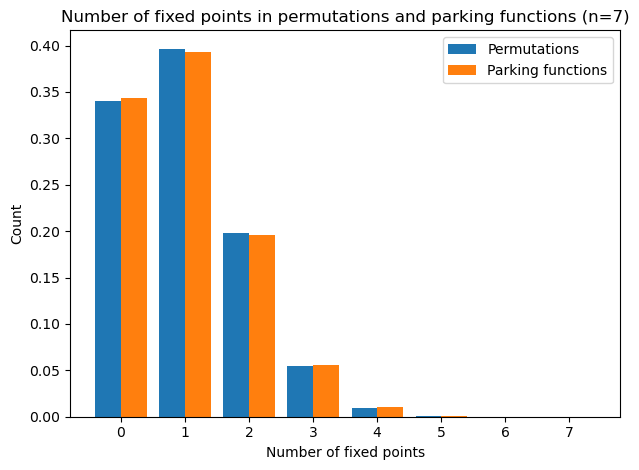

In [74]:
n = 7

width = 0.4 

x = list(range(n + 1))  

perm_counts = np.array(number_of_fixed_points_permutations(n), dtype=float)
park_counts = np.array(number_of_fixed_points_parking_functions(n), dtype=float)
perm_counts /= np.sum(perm_counts)
park_counts /= np.sum(park_counts)


x_perm = [xi - width / 2 for xi in x]
x_park = [xi + width / 2 for xi in x]


plt.bar(x_perm, perm_counts, width=width, label="Permutations")
plt.bar(x_park, park_counts, width=width, label="Parking functions")


plt.xlabel("Number of fixed points")
plt.ylabel("Count")
plt.title(f"Number of fixed points in permutations and parking functions (n={n})")
plt.xticks(x)  
plt.legend()
plt.tight_layout()
#plt.yscale('log')  
plt.show()